# Using convoluted neural network for artist prediction based on given artwork

## In this notebook:
- **About the dataset**
- **Project**
    - Libraries
    - Loading data
    - Data augemntation



# About the dataset

This dataset contains artworks of the 50 most influential artists of all time. This dataset contains three files:

* artists.csv: dataset of information for each artist
* images.zip: collection of images (full size), divided in folders and sequentially numbered
* resized.zip: same collection but images have been resized and extracted from folder structure

Source of dataset:https://www.kaggle.com/ikarus777/best-artworks-of-all-time




## Libraries

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.image import imread
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix

## Loading data

In [2]:
DATA_DIR = "E:/Artworks/data"
df = pd.read_csv(DATA_DIR + "/datasets_130081_310927_artists.csv")
df.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


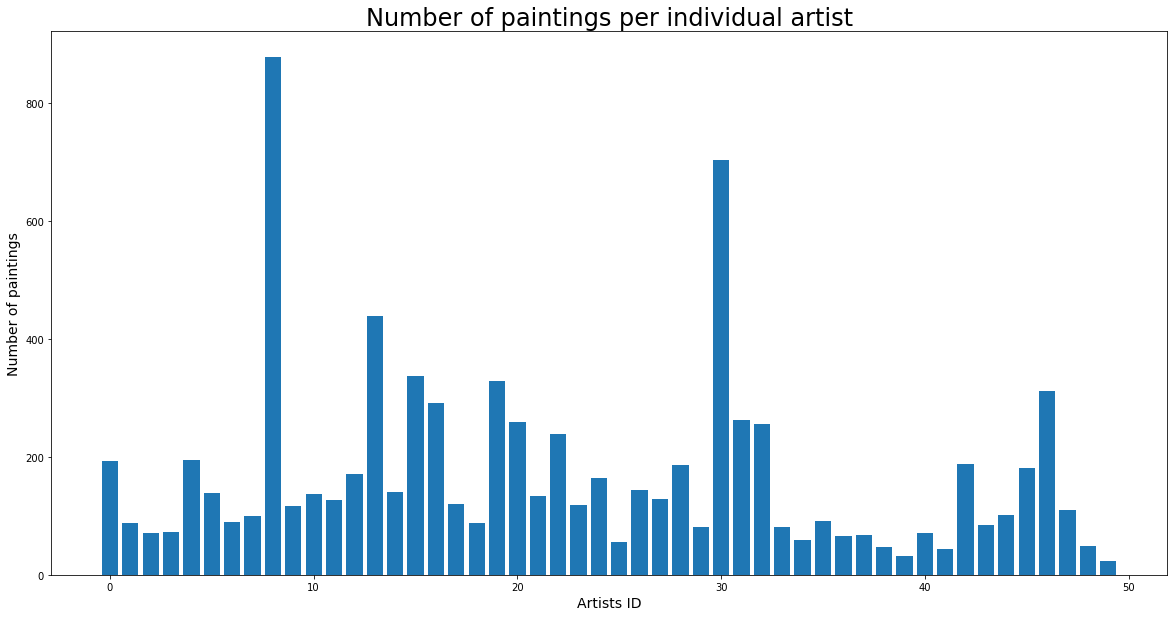

In [3]:
plt.figure(figsize=(20,10))
plt.bar(df["id"], df["paintings"])
plt.title("Number of paintings per individual artist", fontsize=24)
plt.xlabel("Artists ID", fontsize=14)
plt.ylabel("Number of paintings", fontsize=14)
plt.show()

There are many different artists and disproportion between number of artworks is big. Therefore I will chose 6 artists with most paintings

In [4]:
df2 = df.sort_values("paintings", ascending=False)[:6]
df2

,id,name,years,genre,nationality,bio,wikipedia,paintings
8,8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877
30,30,Edgar Degas,1834 - 1917,Impressionism,French,Edgar Degas (US: or UK: ; born Hilaire-Germai...,http://en.wikipedia.org/wiki/Edgar_Degas,702
13,13,Pablo Picasso,1881 - 1973,Cubism,Spanish,Pablo Ruiz Picasso (; Spanish: [ˈpaβlo piˈkaso...,http://en.wikipedia.org/wiki/Pablo_Picasso,439
15,15,Pierre-Auguste Renoir,1841 - 1919,Impressionism,French,"Pierre-Auguste Renoir, commonly known as Augus...",http://en.wikipedia.org/wiki/Pierre-Auguste_Re...,336
19,19,Albrecht Dürer,1471 - 1528,Northern Renaissance,German,Albrecht Dürer (; German: [ˈʔalbʁɛçt ˈdyːʁɐ]; ...,http://en.wikipedia.org/wiki/Albrecht_Dürer,328
46,46,Paul Gauguin,1848 – 1903,"Symbolism,Post-Impressionism",French,"Eugène Henri Paul Gauguin (UK: , US: ; French:...",http://en.wikipedia.org/wiki/Paul_Gauguin,311


In [5]:
IMAGES_DIR = DATA_DIR + "/images_input"
artists = os.listdir(IMAGES_DIR)

In [6]:
dim1_list = []
dim2_list = []

for artist in artists:
    for image_filename in os.listdir(IMAGES_DIR + "/" + artist):
        image = imread(IMAGES_DIR + "/" + artist + "/" +image_filename)
        dim1 = image.shape[0]
        dim2 = image.shape[1]
        dim1_list.append(dim1)
        dim2_list.append(dim2)

Median shape of artworks:        (1024.00, 1000.00)
Average shape of artworks:       (1071.88, 1071.88)


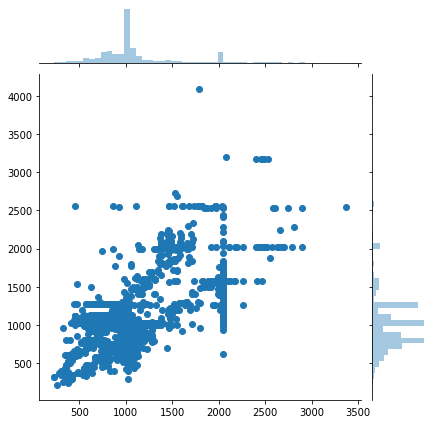

In [7]:
dim1_median = np.median(dim1_list)
dim2_median = np.median(dim2_list)
dim1_mean = np.mean(dim1_list)
dim2_mean = np.mean(dim1_list)
sns.jointplot(dim1_list, dim2_list)

print("Median shape of artworks:        ({0:0.2f}, {1:0.2f})".format(dim1_median, dim2_median))
print("Average shape of artworks:       ({0:0.2f}, {1:0.2f})".format(dim1_mean, dim2_mean))

In [8]:
#image_shape = (1024, 1024, 3)
image_shape = (256, 256, 3)

## Data Augmentation

In [24]:
image_gen = ImageDataGenerator(validation_split=0.3,
                               rescale=1/255,
                               rotation_range=10,
                               horizontal_flip=True,
                               vertical_flip=True,
                               zoom_range=0.1,
                               shear_range=0.1)

train_gen = image_gen.flow_from_directory(directory=IMAGES_DIR,
                                          class_mode='categorical',
                                          target_size=image_shape[:2],
                                          batch_size = 32,
                                          subset="training",
                                          shuffle=True,
                                          classes=artists)

test_gen = image_gen.flow_from_directory(directory=IMAGES_DIR,
                                          class_mode='categorical',
                                          target_size=image_shape[:2],
                                          batch_size = 32,
                                          subset="validation",
                                          shuffle=True,
                                          classes=artists)

Found 2098 images belonging to 6 classes.
Found 895 images belonging to 6 classes.


## Building the CNN model

In [43]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(4,4),input_shape=image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(6, activation="softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [44]:
results = model.fit_generator(train_gen,epochs=50,
                              validation_data=test_gen,
                             callbacks=[early_stop])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 132 steps, validate for 56 steps
Epoch 1/50
132/132 [==============================] - 305s 2s/step - loss: 4.6689 - accuracy: 0.3084 - val_loss: 1.5567 - val_accuracy: 0.3385
Epoch 2/50
132/132 [==============================] - 306s 2s/step - loss: 1.5529 - accuracy: 0.3932 - val_loss: 1.5100 - val_accuracy: 0.4771
Epoch 3/50
132/132 [==============================] - 296s 2s/step - loss: 1.4732 - accuracy: 0.4409 - val_loss: 1.5670 - val_accuracy: 0.3743
Epoch 4/50
132/132 [==============================] - 287s 2s/step - loss: 1.4227 - accuracy: 0.4604 - val_loss: 1.3340 - val_accuracy: 0.5017
Epoch 5/50
132/132 [==============================] - 289s 2s/step - loss: 1.3746 - accuracy: 0.4976 - val_loss: 1.4049 - val_accuracy: 0.4436
Epoch 6/50
132/132 [==============================] - 290s 2s/step - loss: 1.3268 - accuracy: 0.4924 - val_loss: 1.2748 - val_accuracy: 0.5140
Epoch 7/50
132/132 [=============================

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1085: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1085: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


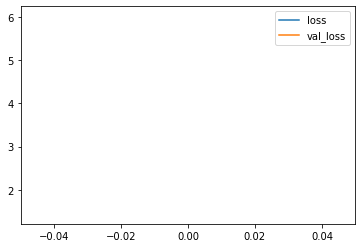

In [28]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

In [45]:
prediction_prob = model.predict(test_gen)
prediction_prob

array([[1.85094686e-04, 6.05126500e-01, 3.67434658e-02, 2.93185618e-02,
        2.32822299e-01, 9.58039463e-02],
       [1.51238982e-02, 3.53684336e-01, 2.06182823e-01, 1.11998163e-01,
        2.01725185e-01, 1.11285649e-01],
       [3.12507676e-04, 4.79495943e-01, 1.07759289e-01, 2.18284894e-02,
        2.23787174e-01, 1.66816488e-01],
       ...,
       [4.40814167e-01, 7.80102983e-02, 5.00946157e-02, 2.88929611e-01,
        3.91306356e-02, 1.03020653e-01],
       [1.41958147e-01, 3.25262904e-01, 7.68276304e-02, 1.62139446e-01,
        1.53868929e-01, 1.39942989e-01],
       [1.77741840e-01, 1.11415826e-01, 2.19821796e-01, 1.43013835e-01,
        9.41360071e-02, 2.53870666e-01]], dtype=float32)

In [ ]:
model.evaluate_generator(train_gen, verbose=1)

  ...
    to  
  ['...']
 27/132 [=====>........................] - ETA: 2:09 - loss: 0.9981 - accuracy: 0.6412

In [30]:
model.evaluate(test_gen, verbose=1)

  ...
    to  
  ['...']
56/56 [==============================] - 82s 1s/step - loss: 1.4499 - accuracy: 0.4335


[1.449904888868332, 0.43351954]